In [1]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

In [2]:
PATH = Path('../../downloads/flight-delays-fall-2018/')

In [3]:
train_df = pd.read_csv(PATH / 'flight_delays_train.csv')

# Exploratory Data Analysis

In [4]:
# Viz with Plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly_express as px

# Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
vis_df = train_df.copy()
# Clean month, day of month and day of week
vis_df['Month'] = vis_df['Month'].str[2:].astype('int')
vis_df['DayofMonth'] = vis_df['DayofMonth'].str[2:].astype('int')
vis_df['DayOfWeek'] = vis_df['DayOfWeek'].str[2:].astype('int')
vis_df.sample(10)

Month  DayofMonth  DayOfWeek  DepTime UniqueCarrier Origin Dest  \
21937      7          13          3     1915            EV    TOL  CVG   
11784      3          31          4      915            OH    CVG  HTS   
50001      1          26          3     1315            OH    MCO  CVG   
49134     12          11          1      758            UA    HNL  SFO   
24254     12          12          1     1920            WN    ONT  PHX   
44422     11          28          1     1854            XE    CLE  BTV   
9228       4          13          4      803            YV    DSM  ORD   
31619      3          13          7     1942            US    SJU  PHL   
59174      2           3          4     2229            NW    SFO  DTW   
23424     10          27          4     1326            AA    DFW  CMH   

       Distance dep_delayed_15min  
21937       181                 Y  
11784       123                 N  
50001       756                 N  
49134      2398                 N  
24254       325                 N  
44422       489                 N  
9228        299                 N  
31619      1576                 Y  
59174      2079                 N  
23424       927                 N

## 01 Check the target variable dep_delayed_15min


In [6]:
# Check the target variable
trace = [go.Bar(
            x = vis_df['dep_delayed_15min'].value_counts().index.values,
            y = vis_df['dep_delayed_15min'].value_counts().values,
            #x = levels,
            #text='Distribution of target variable',
            marker = dict(color='red', opacity=0.6)
    )]


layout = dict(title="Target variable,15 min Delay, distribution", 
              margin=dict(l=100), 
              width=400, 
              height=400)

fig = go.Figure(data=trace, layout=layout)

iplot(fig)

## 02 Plot the UniqueCarrier and their frequencies.

In [7]:
trace = [go.Bar(
    x = vis_df['UniqueCarrier'].value_counts().index.values,
    y = vis_df['UniqueCarrier'].value_counts().values,
    marker = dict(color='blue', opacity=0.6)
)]

layout = dict(title='Carrier wise flight distribution',
             width=800,
             height=400,
             xaxis = dict(title="Unique Carrier", tickmode='linear', tickangle=-45))
fig = go.Figure(data=trace, layout=layout)

iplot(fig)

## 03 Plot the UniqueCarrier and Delay

In [55]:
trace1 = go.Bar(
    x = vis_df[vis_df['dep_delayed_15min'] == "Y"]['UniqueCarrier'].value_counts().index.values,
    y = vis_df[vis_df['dep_delayed_15min'] == "Y"]['UniqueCarrier'].value_counts().values,
    name= 'Yes',
    marker = dict(color='red', opacity=0.6)
)

trace2 = go.Bar(
    x = vis_df[vis_df['dep_delayed_15min'] == "N"]['UniqueCarrier'].value_counts().index.values,
    y = vis_df[vis_df['dep_delayed_15min'] == "N"]['UniqueCarrier'].value_counts().values,
    name= 'No',
    marker = dict(color='grey', opacity=0.6)
)

layout = go.Layout(title= 'Carrier wise flight distribution by Delay',
                   xaxis=dict(title='Unique Carrier', tickangle=-45),
                  barmode='group')

data = [trace1, trace2]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## 04 Plot histogram for Distance.

In [65]:
# data = [go.Histogram(
#     x = vis_df['Distance'].value_counts().index.values,
#     y = vis_df['Distance'].value_counts().values
# )]

data = [go.Histogram(
    x = vis_df['Distance']
)]
iplot(data)

## 05 Plot the histogram of Distance with Delay

In [85]:
# trace1 = go.Histogram(
# )
trace1 = go.Histogram(
    x = vis_df[vis_df['dep_delayed_15min'] == 'Y']['Distance'],
    marker=dict(color='red', opacity=0.6),
    name = 'Yes'
)
trace2 = go.Histogram(
    x = vis_df[vis_df['dep_delayed_15min'] == 'N']['Distance'],
    marker=dict(color='blue', opacity=0.6),
    name = 'No'
)
layout = go.Layout(title='Distance traveled and Delay', barmode='overlay')
data=[trace1, trace2]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Create new features

In [102]:
vis_df['Dep_hour'] =  vis_df['DepTime']//100
vis_df['Dep_minute'] =  vis_df['DepTime']%100
vis_df['Dep_hour'].replace(to_replace=[24,25], value=0, inplace=True)
vis_df.sample(10)

Month  DayofMonth  DayOfWeek  DepTime UniqueCarrier Origin Dest  \
50976      1           5          4      720            WN    MCO  FLL   
48412     10           6          5     1125            OO    LAX  IPL   
58797      7          14          4     2112            OO    LAX  SMX   
89397      1           3          1     1345            UA    SAN  SFO   
36511      6          24          5     1805            OO    SBA  LAX   
99114      4           1          6     1624            UA    JFK  LAX   
61882     10           6          4     1635            WN    MCO  BWI   
98067      3          12          7      602            CO    LAX  IAH   
45086      6          14          3      923            FL    DTW  BWI   
24504      8          19          6      915            XE    MEM  IAH   

       Distance dep_delayed_15min  Dep_hour  Dep_minute  
50976       178                 N         7          20  
48412       181                 Y        11          25  
58797       135                 N        21          12  
89397       447                 N        13          45  
36511        89                 N        18           5  
99114      2475                 N        16          24  
61882       787                 Y        16          35  
98067      1379                 N         6           2  
45086       408                 N         9          23  
24504       469                 N         9          15

## 06 Plot the departure hour and the delay

In [2]:
df_t = pd.crosstab(vis_df.Dep_hour,vis_df.dep_delayed_15min)
trace1 = go.Scatter(
    x = df_t.index,
    y = df_t.N,
    mode = 'lines+markers',
    name='No Delays')
trace2 = go.Scatter(
    x = df_t.index,
    y = df_t.Y,
    mode = 'lines+markers',
    name='Delays')
data = [trace1, trace2]
layout = go.Layout(title='Departure hour and Delay')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

NameError: name 'pd' is not defined

In [173]:
vis_df['Dep_hour_flag'] = ((vis_df['Dep_hour'] >= 6) & (vis_df['Dep_hour'] < 23)).astype("int")
df_t = pd.crosstab(vis_df.Dep_hour_flag, vis_df.dep_delayed_15min)
df_t

dep_delayed_15min      N      Y
Dep_hour_flag                  
0                   2272    629
1                  78684  18415

In [190]:
trace1 = go.Scatter(
    x = df_t.index,
    y = df_t['N'],
    mode = 'lines+markers',
    name = 'No delay'
)

trace2 = go.Scatter(
    x = df_t.index,
    y = df_t['Y'],
    mode = 'lines+markers',
    name = 'Delay'
)
data = [trace1,trace2]
layout = go.Layout(title="Departure hour and Delay")
fig = go.Figure(data=data, layout=layout)
iplot(fig)
# df_t['N']

## 07 Boxplots

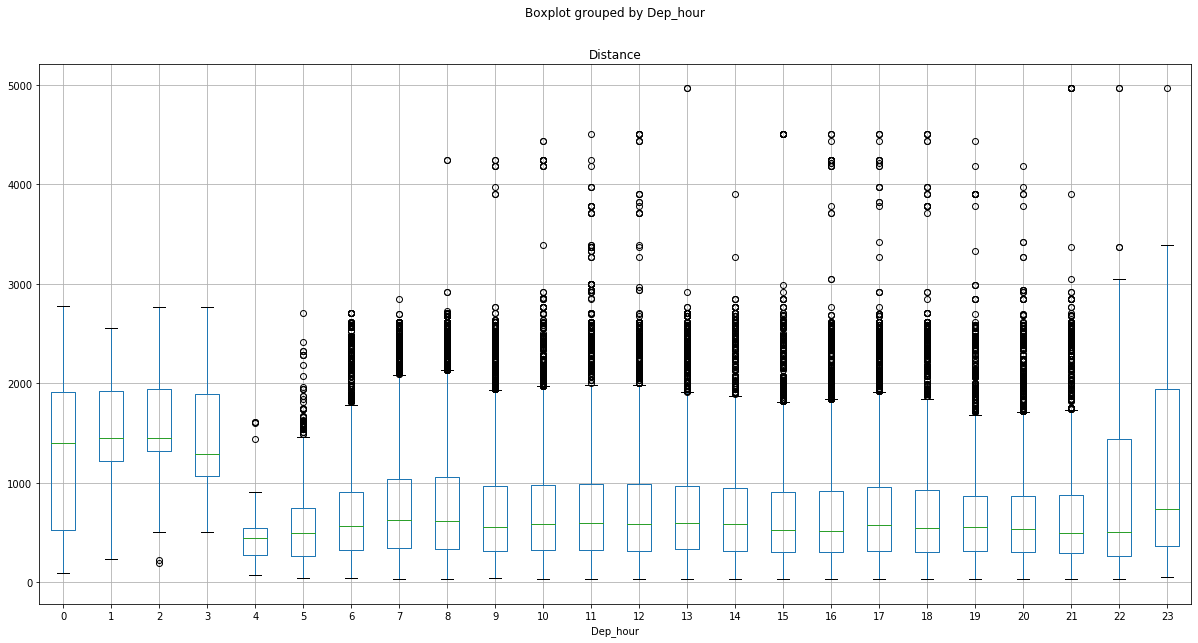

In [195]:
vis_df.boxplot(column="Distance",by="Dep_hour", figsize=(20,10))

# Feature Engineering

In [10]:
def seasonify(monthvalues):
    summer = []
    for i in monthvalues:
        if i in ['c-6','c-7','c-8']:
            summer.append('c-1')
        elif i in ['c-9','c-10','c-11']:
            summer.append('c-2')
        elif i in ['c-12','c-1','c-2']:
            summer.append('c-3')
        elif i in ['c-3','c-4','c-5']:
            summer.append('c-4')
    return summer

In [134]:
encoder = LabelEncoder()
test_df = pd.read_csv(PATH / 'flight_delays_test.csv')
# test_df = test_df.drop('Dest', axis=1)
# test_df['Dest'] = b
# test_df = test_df.drop('DayofMonth', axis=1)
test_df['UniqueCarrier'] = encoder.fit_transform(test_df['UniqueCarrier'])
test_df['Month'] = seasonify(test_df.Month.values)
test_df['flight'] = test_df['Origin'] + '-->' + train_df['Dest']
test_df['UniqueCarrier'] = test_df['UniqueCarrier'].map(lambda x: 'c-'+str(x+1))
# test_df['DepTime'] = test_df['DepTime'].map(lambda x: x//100)
# test_df['DepTime'] = test_df['DepTime'].map(lambda x: 'c-'+str(x))

# test_df['summer'] = (test_df['Month'].isin(['c-6','c-7','c-8']).astype(np.int32))
# test_df['autumn'] = (test_df['Month'].isin(['c-9','c-10','c-11']).astype(np.int32))
# test_df['winter'] = (test_df['Month'].isin(['c-12','c-1','c-2']).astype(np.int32))
# test_df['spring'] = (test_df['Month'].isin(['c-3','c-4','c-5']).astype(np.int32))
test_df = test_df.drop(['DayofMonth'], axis=1)
# test_df = test_df.drop(['DayofMonth','Origin','Dest'], axis=1)
test_df

Month DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance     flight
0       c-1       c-3      615          c-20    MRY  PHX       598  MRY-->DFW
1       c-4       c-2      739          c-18    LAS  HOU      1235  LAS-->MCO
2       c-3       c-7      651          c-12    GSP  ORD       577  GSP-->CLE
3       c-4       c-7     1614          c-18    BWI  MHT       377  BWI-->MEM
4       c-1       c-3     1505          c-16    ORD  STL       258  ORD-->OMA
...     ...       ...      ...           ...    ...  ...       ...        ...
99995   c-1       c-2      852          c-18    CRP  HOU       187  CRP-->RDD
99996   c-2       c-6     1446          c-16    ORD  LAS      1515  ORD-->DAB
99997   c-3       c-2     1509          c-15    ORD  SGF       438  ORD-->IAH
99998   c-3       c-5      804           c-7    LGA  ATL       761  LGA-->GGG
99999   c-2       c-1      834          c-15    MKE  MSP       297  MKE-->SMF

[100000 rows x 8 columns]

In [169]:
dft = df.copy()
dft['Month'] = dft['Month'].str[2:].astype('int')
dft = dft.rename(columns={'Month':'Season'})
trace1 = go.Bar(
    x = dft[dft['dep_delayed_15min'] == 'Y']['Season'].value_counts().index.values,
    y = dft[dft['dep_delayed_15min'] == 'Y']['Season'].value_counts().values,
    name = 'Delay'
#     marker= dict(color=)
)
trace2 = go.Bar(
    x = dft[dft['dep_delayed_15min'] == 'N']['Season'].value_counts().index.values,
    y = dft[dft['dep_delayed_15min'] == 'N']['Season'].value_counts().values,
    name = 'No Delay'
)
data = [trace1, trace2]
layout = go.Layout(title='Season and delay')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [6]:
train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']

In [183]:
df = train_df.copy()

# df['Month'] = seasonify(df.Month.values)

# encoder = LabelEncoder()
# df.UniqueCarrier.nunique()
df['UniqueCarrier'] = encoder.fit_transform(df['UniqueCarrier'])
# df['DepTime'] = df['DepTime'].map(lambda x: x//100)
# df['DepTime'] = df['DepTime'].map(lambda x: 'c-'+str(x))
df['UniqueCarrier'] = df['UniqueCarrier'].map(lambda x: 'c-'+str(x+1))
# df = df.drop(['DayofMonth','Origin','Dest'], axis=1)
# df['summer'] = (df['Month'].isin(['c-6','c-7','c-8']).astype(np.int32))
# df['autumn'] = (df['Month'].isin(['c-9','c-10','c-11']).astype(np.int32))
# df['winter'] = (df['Month'].isin(['c-12','c-1','c-2']).astype(np.int32))
# df['spring'] = (df['Month'].isin(['c-3','c-4','c-5']).astype(np.int32))
# df = df.drop(['DayofMonth'], axis=1)
df['Dep_hour'] =  df['DepTime']//100
df['Dep_minute'] =  df['DepTime']%100
df['Dep_hour'].replace(to_replace=[24,25], value=0, inplace=True)
df['Dep_hour_flag'] = ((df['Dep_hour'] >= 6) & (df['Dep_hour'] < 23)).astype("int")
df['Dep_hour_flag'] = df['Dep_hour_flag'].map(lambda x: 'c-'+str(x))
df

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0       c-8       c-21       c-7     1934           c-1    ATL  DFW       732   
1       c-4       c-20       c-3     1548          c-19    PIT  MCO       834   
2       c-9        c-2       c-5     1422          c-21    RDU  CLE       416   
3      c-11       c-25       c-6     1015          c-16    DEN  MEM       872   
4      c-10        c-7       c-6     1828          c-20    MDW  OMA       423   
...     ...        ...       ...      ...           ...    ...  ...       ...   
99995   c-5        c-4       c-3     1618          c-16    SFO  RDD       199   
99996   c-1       c-18       c-3      804           c-5    EWR  DAB       884   
99997   c-1       c-24       c-2     1901          c-14    DTW  IAH      1076   
99998   c-4       c-27       c-4     1515          c-13    DFW  GGG       140   
99999  c-11       c-17       c-4     1800          c-20    SEA  SMF       605   

      dep_delayed_15min  Dep_hour  Dep_minute Dep_hour_flag  
0                     N        19          34           c-1  
1                     N        15          48           c-1  
2                     N        14          22           c-1  
3                     N        10          15           c-1  
4                     Y        18          28           c-1  
...                 ...       ...         ...           ...  
99995                 N        16          18           c-1  
99996                 N         8           4           c-1  
99997                 N        19           1           c-1  
99998                 N        15          15           c-1  
99999                 N        18           0           c-1  

[100000 rows x 12 columns]

In [184]:
categ_feat_idx = np.where(df.drop('dep_delayed_15min', axis=1).dtypes == 'object')[0]
categ_feat_idx
# condition = True
# cat_features_names = [col for col in df.columns if condition]
# cat_features = [df.columns.get_loc(col) for col in cat_features_names]
# print(cat_features)

array([ 0,  1,  2,  4,  5,  6, 10])

In [169]:
X_train = df.drop('dep_delayed_15min', axis=1).values
y_train = df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df.values

In [170]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [171]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': categ_feat_idx,
#           'task_type': 'GPU',
          'verbose': 200,
          'random_seed': 17
         }

ctb = CatBoostClassifier(**params)
ctb.fit(X_train_part, y_train_part,
          eval_set=(X_valid, y_valid),
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.121895
0:	test: 0.6597529	best: 0.6597529 (0)	total: 327ms	remaining: 5m 26s
200:	test: 0.7214828	best: 0.7214828 (200)	total: 28.4s	remaining: 1m 52s
400:	test: 0.7255267	best: 0.7255486 (399)	total: 52.9s	remaining: 1m 19s
600:	test: 0.7277137	best: 0.7278171 (597)	total: 1m 16s	remaining: 50.7s
800:	test: 0.7285190	best: 0.7286070 (790)	total: 1m 40s	remaining: 25s
999:	test: 0.7303630	best: 0.7303957 (986)	total: 2m 4s	remaining: 0us

bestTest = 0.7303956922
bestIteration = 986

Shrink model to first 987 iterations.


In [172]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

In [173]:
roc_auc_score(y_valid, ctb_valid_pred)

0.7303956922270072

In [174]:
ctb.fit(X_train, y_train,
        cat_features=categ_feat_idx,
        eval_set=(X_valid, y_valid),
        use_best_model=True,
        plot=True
        );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.126547
0:	test: 0.6447226	best: 0.6447226 (0)	total: 542ms	remaining: 9m 1s
200:	test: 0.7679346	best: 0.7679346 (200)	total: 32.8s	remaining: 2m 10s
400:	test: 0.8035026	best: 0.8035868 (398)	total: 1m 5s	remaining: 1m 37s
600:	test: 0.8189509	best: 0.8189875 (599)	total: 1m 36s	remaining: 1m 3s
800:	test: 0.8269111	best: 0.8269111 (800)	total: 2m 5s	remaining: 31.3s
999:	test: 0.8349702	best: 0.8349702 (999)	total: 2m 36s	remaining: 0us

bestTest = 0.8349701894
bestIteration = 999



In [175]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]
# X_test[0]

In [176]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv(PATH / 'sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv('ctb_pred.csv')